# Data epidemic of COVID-19 in Catalonia

The datoscovid.cat website comes into operation 28th of July 2020 to monitor the epidemiological epidemic of COVID-19 in Catalonia.

First, the imports for the notebook.

In [1]:
# Data
import pandas as pd
import numpy as np


import warnings
warnings.filterwarnings('ignore')

# Plot
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

# Models
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn import metrics
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn import linear_model


from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets



## Find Data 

We downloaded the data the 17th of november 2020, but you can download an updated version from the website https://dadescovid.cat/descarregues.

You can also find other data in [transparenciacatalunya.cat](https://analisi.transparenciacatalunya.cat/Salut/Registre-de-defuncions-per-COVID-19-a-Catalunya-Se/uqk7-bf9s).



## FIRST PART USING DATA FROM CATALUNYA

Let's try to use linear regression to fit a curve to the data.


## 1. Data preparation

Read and preprocess the data in the following cells, before applying any model.


In [2]:
# Load data

pandemic_diari = pd.read_csv('data/catalunya_diari.csv', sep=';')
print(pandemic_diari.shape)
pandemic_diari.head()

(4437, 14)


,NOM,CODI,DATA,SEXE,GRUP_EDAT,RESIDENCIA,CASOS_CONFIRMAT,PCR,TAR,INGRESSOS_TOTAL,INGRESSOS_CRITIC,INGRESSATS_TOTAL,INGRESSATS_CRITIC,EXITUS
0,CATALUNYA,CATALUNYA,2020-11-16,Altres,NaN,--,24,10,14,0,1,101,15,0
1,CATALUNYA,CATALUNYA,2020-11-16,Dona,Entre 15 i 64,No,455,583,2595,0,0,318,67,0
2,CATALUNYA,CATALUNYA,2020-11-16,Dona,Entre 15 i 64,Si,0,6,2,0,0,9,1,0
3,CATALUNYA,CATALUNYA,2020-11-16,Dona,Entre 65 i 74,No,56,77,239,1,4,197,50,0
4,CATALUNYA,CATALUNYA,2020-11-16,Dona,Entre 65 i 74,Si,0,5,4,0,0,5,0,0


In [3]:
pandemic_diari.isnull().sum()

NOM                    0
CODI                   0
DATA                   0
SEXE                   0
GRUP_EDAT            261
RESIDENCIA             0
CASOS_CONFIRMAT        0
PCR                    0
TAR                    0
INGRESSOS_TOTAL        0
INGRESSOS_CRITIC       0
INGRESSATS_TOTAL       0
INGRESSATS_CRITIC      0
EXITUS                 0
dtype: int64

In [4]:
pandemic_diari.isna().sum()

NOM                    0
CODI                   0
DATA                   0
SEXE                   0
GRUP_EDAT            261
RESIDENCIA             0
CASOS_CONFIRMAT        0
PCR                    0
TAR                    0
INGRESSOS_TOTAL        0
INGRESSOS_CRITIC       0
INGRESSATS_TOTAL       0
INGRESSATS_CRITIC      0
EXITUS                 0
dtype: int64

This `GRUP_EDAT` with NaNs correspnds to "Others".

As you can see there are several rows per every data corresponding to different age ranges.
We sum all these instances together to obtain the total number of Covid-19 cases registered per day, hospitalizations per day, ICU patients per day and deaths per day. For that we use the function `groupby` from pandas.

In [5]:
pandemic = pandemic_diari.groupby("DATA").sum()
print(pandemic.shape)
pandemic.head()

(261, 8)


,CASOS_CONFIRMAT,PCR,TAR,INGRESSOS_TOTAL,INGRESSOS_CRITIC,INGRESSATS_TOTAL,INGRESSATS_CRITIC,EXITUS
DATA,,,,,,,,
2020-03-01,2,22,0,0,0,0,0,0
2020-03-02,5,35,0,0,0,0,0,0
2020-03-03,8,25,0,0,0,0,0,0
2020-03-04,7,29,0,0,0,0,0,0
2020-03-05,18,37,0,0,0,0,0,0


Let's see which of these columns we need.

We will discard `PCR` and `TAR` columns. The information about `PCR` and `TAR` can be used to compute **% PCR/TA positives**: proportion of all PCR / TA tests performed that obtain a positive result. This indicator measures the intensity with which an active case search is being performed using outbreak control and contact tracking strategies. One could analyze this interesting indicator. But, not in this notebook... We drop this columns from the dataframe.

We have also two numeric fields `INGRESSOS_TOTAL` and `INGRESSOS_CRITIC` which correpsonds to registered hospital admission data (number of new hospital admissions for COVID-19 that have occurred during a described period) and registered ICU admission data (number of new ICU admissions of patients with COVID-19 during the period described). These patients are included in the admissions, but in the previous days (to be admitted to the ICU are must have previously been admitted to hospital).

So, we are interested in the fields: 
- DATA: data day --> day/month/year
- CASOS_CONFIRMAT: total cases registered per day
- INGRESSATS_TOTAL: hospitalizations per day
- INGRESSATS_CRITIC: ICU patients per day
- EXITUS: deaths per day


For more information about the data you can visit: [Socrata](https://dev.socrata.com/foundry/analisi.transparenciacatalunya.cat/dmzh-fz47).


In [6]:
# Drop not needed columns:
pandemic= pandemic.drop(['PCR', 'TAR', 'INGRESSOS_TOTAL', 'INGRESSOS_CRITIC'], axis=1)
pandemic.head()

,CASOS_CONFIRMAT,INGRESSATS_TOTAL,INGRESSATS_CRITIC,EXITUS
DATA,,,,
2020-03-01,2,0,0,0
2020-03-02,5,0,0,0
2020-03-03,8,0,0,0
2020-03-04,7,0,0,0
2020-03-05,18,0,0,0


In [7]:
# Change column names to:
pandemic=pandemic.rename({'CASOS_CONFIRMAT': 'Cases', 'INGRESSATS_TOTAL': 'Hospitalized',
                             'INGRESSATS_CRITIC': 'ICU', 'EXITUS': 'Dead'}, axis='columns')
pandemic.head()

,Cases,Hospitalized,ICU,Dead
DATA,,,,
2020-03-01,2,0,0,0
2020-03-02,5,0,0,0
2020-03-03,8,0,0,0
2020-03-04,7,0,0,0
2020-03-05,18,0,0,0


Moreover, we could estimate the number of recovered people from the number of hospital discharges, which can be computed as the variation on hospital admission and exitus. But, not in this notebook... We leave this as an exercise.


<div class="alert alert-success" style = "border-radius:10px;border-width:3px;border-color:darkgreen;font-family:Verdana,sans-serif;font-size:16px;">
    
**Exercise:**
Compute the number of recovered population.

</ol>
</div>

In [8]:
# Show data

# Interactive data visualization
def show_data(samples, features):
    colnames=['Date', 'Cases', 'Hospitalized', 'ICU', 'Dead']
    return pandemic.head(samples)

samples = widgets.IntSlider(min=1, max=pandemic.shape[0], value = 1)
features = widgets.IntSlider(min=1, max=pandemic.shape[1], value = 1)
interact(show_data, samples=samples, features=features)


interactive(children=(IntSlider(value=1, description='samples', max=261, min=1), IntSlider(value=1, descriptio…

<function __main__.show_data(samples, features)>

Note: Move the interactive commands to see the content of the table.

**Data description**

Show our data contains:

- Data: data day --> day/month/year
- Cases: total cases registered per day
- Hospitalized: hospitalizations per day
- ICU: ICU patients per day
- Dead: deaths per day

**Remark on data veracity**: We have to take into account that the data may not be complete due to the lack of coordination between different clinicians/hospitals/institutions/governments and, that means, the sum of Covid-19 cases could be higher than the data reflects.

In [9]:
# Convert columns to integer
pandemic['Cases'] = pandemic['Cases'].apply(int)
pandemic['Hospitalized'] = pandemic['Hospitalized'].apply(int)
pandemic['ICU'] = pandemic['ICU'].apply(int)
pandemic['Dead'] = pandemic['Dead'].apply(int)
#pandemic['Date'] = pandemic['Date'].apply(int)

pandemic.head()

,Cases,Hospitalized,ICU,Dead
DATA,,,,
2020-03-01,2,0,0,0
2020-03-02,5,0,0,0
2020-03-03,8,0,0,0
2020-03-04,7,0,0,0
2020-03-05,18,0,0,0


### Visualization of distributions and relationships.

We can try to understand how the pandemic data is behaving.


###### **Relationship between varibles**

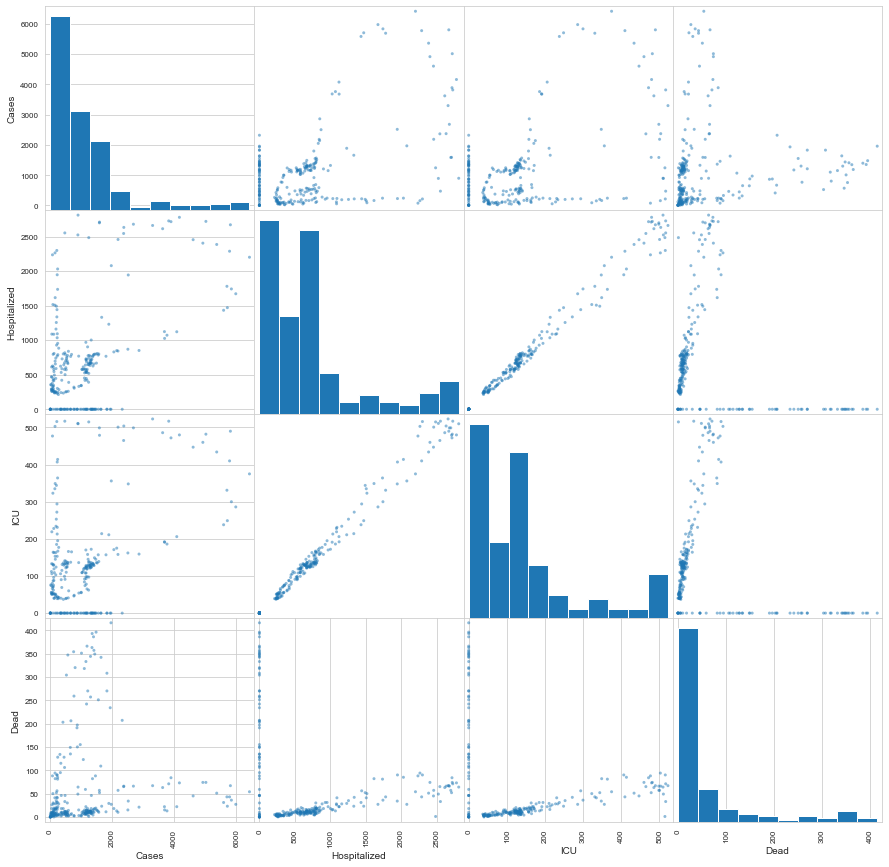

In [10]:
# Compute the relation
from pandas.plotting import scatter_matrix
a = scatter_matrix(pandemic, figsize=(15, 15)) 


<div class="alert alert-success" style = "border-radius:10px;border-width:3px;border-color:darkgreen;font-family:Verdana,sans-serif;font-size:16px;">
    
**Exercise**: Revise the steps and analyze the scatter plot matrix.

</ol>
</div>

###### Histogram

It would be really interesting to analyze the frequency of the data. We can visualize it using a histogram.



In [11]:
# Histogram visualization
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

@interact
def histogram(feature=list(pandemic.select_dtypes('number').columns)):
    pandemic.hist(feature, bins=len(pandemic[feature].unique()), figsize=(15,15))

interactive(children=(Dropdown(description='feature', options=('Cases', 'Hospitalized', 'ICU', 'Dead'), value=…

Move the interactive command to see the different plots.

As we can see from the data distribution, low numbers are more frequent because it was the beginning of the pandemic. As the pandemic progresses, it is possible to see how more people are infected and the numbers change with greater speed.

At the moment we find another frequency spike, we can say that the numbers are stabilizing. Hence, the pandemic is also stabilizing.

In [12]:
pandemic.columns

Index(['Cases', 'Hospitalized', 'ICU', 'Dead'], dtype='object')

### Scatter plots

Before applying any model, we need to visualize the data for every day.

Let's consider the date as an incremental variable where the first date of our dataset corresponds to day 0. In the next cell we create X with this idea.

In [13]:
# Create X and y 
X = pd.Series(range(0,len(pandemic)))
Y = pandemic


In [14]:
# date could also be printed as x-ticks in the next plot.
x_ticks_labels = pandemic.index

In [15]:
# Plot 

@interact
def vis(column=list(Y.select_dtypes('number').columns)):
    plt.figure(figsize=(10, 10)) 
    #limitation_days = 60
    plt.scatter(X, Y[column], color='red')
    plt.xlabel('Days from day1')
    plt.ylabel('Log(cumY) {}'.format(column))
    plt.ylim((1, 1.2*max(Y[column])))
    #plt.xticks(X,x_ticks_labels, rotation='vertical')



interactive(children=(Dropdown(description='column', options=('Cases', 'Hospitalized', 'ICU', 'Dead'), value='…

Move the interactive command to see the different plots.

In [16]:
# In logarithmic scale

y_logarithmic = Y.copy()

y_logarithmic['Cases'] = np.log10(Y)['Cases'].replace([np.inf, -np.inf], 0)
y_logarithmic['Dead'] = np.log10(Y)['Dead'].replace([np.inf, -np.inf], 0)
y_logarithmic['ICU'] = np.log10(Y)['ICU'].replace([np.inf, -np.inf], 0)
y_logarithmic['Hospitalized'] = np.log10(Y)['Hospitalized'].replace([np.inf, -np.inf], 0)


@interact
def logs(column=list(y_logarithmic.select_dtypes('number').columns)):
    plt.figure(figsize=(10, 10)) 
    #limitation_days = 60
    plt.scatter(X, y_logarithmic[column], color='red')
    plt.xlabel('Days from day1')
    plt.ylabel('Log(cumY) {}'.format(column))
    plt.ylim((1, 1.2*max(y_logarithmic[column])))
    #plt.xlim((1, limitation_days))


interactive(children=(Dropdown(description='column', options=('Cases', 'Hospitalized', 'ICU', 'Dead'), value='…

In [17]:
column=list(y_logarithmic.select_dtypes('number').columns)
print(column)

['Cases', 'Hospitalized', 'ICU', 'Dead']


<div class="alert alert-success" style = "border-radius:10px;border-width:3px;border-color:darkgreen;font-family:Verdana,sans-serif;font-size:16px;">
    
**Exercise:** For plotting 'cases' it is probably better to do an average with a window of 7 or 14 days. Try it!

</ol>
</div>


## 2. Data processing

We have already understood the data, the next step is to do the fitting of a regression model

##### **Split data**


We should split the data into predictor and response. In the predictor we have the days and in response we will have to choose the variable to predict, in our case, could be Cases, Hospitalized, ICU or Dead

Once the data is splitted into predictor and response, the model needs data to train and data to test. In this case, we are going to train the model with 75% of the data and 25% to test the performance of the model.
    
<figure>
<center>
<img src='https://drive.google.com/uc?id=1IDfAfyVgGiapum1Cy4WhdbLTdGTbIZwc' width=500 height=300/>
</figure>


In [18]:
# Split data into X and Y
X = pd.Series(range(0,len(pandemic)))
Y = pandemic

# Finally split X and Y into 75 % training and 25 % test
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.25, shuffle=True,random_state=30)

X_train = np.expand_dims(X_train, axis=1)
X_test = np.expand_dims(X_test, axis=1)

#### **Regression models**



In [19]:

# Linear Regression
columns = ['Cases', 'Hospitalized', 'ICU', 'Dead', 'Recovered']
day_to_predict = widgets.IntSlider(min=30, max=100, value = 1)

def lrmodel(column=list(y_logarithmic.select_dtypes('number').columns)):
    model = LinearRegression() 
    y_train = Y_train[column]
    y_test = Y_test[column]

    y_df = np.concatenate((y_train, y_test))
    x_df = np.concatenate((X_train, X_test))

    model.fit(X_train, y_train)

    ##
    days_to_predict = [index for index in range(X.iloc[-1]+1, X.iloc[-1]+11)]
    days_to_predict=np.array(days_to_predict)
    days_to_predict = np.expand_dims(days_to_predict, axis=1)

    x = np.concatenate((x_df, days_to_predict))

    #y_pred = model.predict(days_to_predict)

    #y_pred_test = model.predict(X_test)

    
    plt.figure(figsize=(10, 10)) 
    plt.scatter(x_df, y_df, color='red', label='Data')
    plt.plot(x, model.predict(x), color='blue', label='Predicted')
    plt.xlabel('Days')
    plt.ylabel(column)
    plt.ylim(0)
    plt.legend(loc='best')
    
    print('Training MSE: {}'.format(np.mean((model.predict(X_train) - y_train)**2)))
    print("Training R^2: {}".format(metrics.r2_score(model.predict(X_train), y_train)))
    print('Test MSE: {}'.format(np.mean((model.predict(X_test) - y_test)**2)))
    print("Test R^2: {}".format(metrics.r2_score(model.predict(X_test), y_test)))    

model = interact(lrmodel)


interactive(children=(Dropdown(description='column', options=('Cases', 'Hospitalized', 'ICU', 'Dead'), value='…

In [20]:
days_to_predict = [index for index in range(X.iloc[-1]+1, X.iloc[-1]+11)]
days_to_predict=np.array(days_to_predict)
days_to_predict = np.expand_dims(days_to_predict, axis=1)

days_to_predict

array([[261],
       [262],
       [263],
       [264],
       [265],
       [266],
       [267],
       [268],
       [269],
       [270]])

We can see the line follows the data trend but the result are not enough because the line doesn't fit the real data. 

In fact, our linear regression models is far from making a good prediction.


##### **Polynomial Regression Model**

There is another interesting method called polynomial regression. In essence, it is like a linear regression where the relationship between variables is performed as an **n** degree polynomial.


<figure>
<br/>
<center>
<img src='https://drive.google.com/uc?id=18cH6qMnkhyKEuc1qYpgI878jTi7cz0GL' width = '400' />
<br/>
</figure>

It has the flexibility to bend. However, it follows a curve shape and won't fit to the data perfectly.

In [21]:
# Fitting Polynomial Regression to the dataset
from sklearn.preprocessing import PolynomialFeatures

def polyregressionmodel(column=list(y_logarithmic.select_dtypes('number').columns)):

  y = y_logarithmic[column]

  poly_reg = PolynomialFeatures(degree=4)
  X_poly = poly_reg.fit_transform(np.expand_dims(X, axis=1))
  pol_reg = LinearRegression()
  pol_reg.fit(X_poly, y)

  days_to_predict = [index for index in range(X.iloc[-1]+1, X.iloc[-1]+11)]
  days_to_predict = np.array(days_to_predict)
  x = np.concatenate((X, days_to_predict))

  y_poly_pred_train = pol_reg.predict(poly_reg.fit_transform(np.expand_dims(X, axis=1)))
  y_poly_pred = pol_reg.predict(poly_reg.fit_transform(np.expand_dims(x, axis=1)))

  # Visualizing the Polymonial Regression results
  def viz_polymonial(y_poly_pred):
      plt.figure(figsize=(10, 10))
      plt.scatter(X, y, color='red',label='Data')
      plt.plot(x, y_poly_pred, color='blue', label = 'Predicted')
      plt.title('Polymonial Regression')
      plt.xlabel('Days')
      plt.ylabel(column)
      plt.legend(loc='best')
      plt.show()
      return
  viz_polymonial(y_poly_pred)
  
  rmse = np.sqrt(mean_squared_error(y,y_poly_pred_train))
  r2 = r2_score(y,y_poly_pred_train)

  print("RMSE: ", rmse)
  print("R2: ", r2)


model = interact(polyregressionmodel)


interactive(children=(Dropdown(description='column', options=('Cases', 'Hospitalized', 'ICU', 'Dead'), value='…

As we expected, it fits the data better than a simple linear regression but its performance is not enough to have a good prediction.

##### **LOcally Estimated Scatterplot Smoothing (LOESS)**

The next method is LOESS. It fits a smooth curve between two variables combining the simplicity of linear regression with the flexibility of nonlinear regressions. Also, LOESS has the capacity of fitting smoothing curve without prior assumption about the form or shape of the curve.


<figure>
<br/>
<center>
<img src='https://drive.google.com/uc?id=1inz4nluW15Atz3Q4bkFQv248M3XP0p2o' width = '400' />
<br/>
</figure>


They address situations where classifcal methods do not work or cannot be effectively applied. In our pandemic case, we need a flexible curve that adapts to our data and this can be achieved with nonlinear methods. 

Let's test it with the pandemic data, we can predict the next 10 days.



In [22]:
# LOESS IN LOGARITMIC SCALE

from skmisc.loess import loess, loess_prediction 

def loessmodel(column=list(y_logarithmic.select_dtypes('number').columns)):

  lo = loess(X, y_logarithmic[column], span=0.1, p=1, surface='direct', degree =1)
  lo.fit()

  days_to_predict = [index for index in range(X.iloc[-1]+1, X.iloc[-1]+11)]
  days_to_predict = np.array(days_to_predict)


  x = np.concatenate((X, days_to_predict))
  prediction = lo.predict(x)
  
  
  prediction_int = [10**number_log for number_log in prediction.values]
  last_ten_days = prediction_int[-11:]
  # if column=='Cases' or column=='Dead':
  #   new_cases = [last_ten_days[day+1] - last_ten_days[day] for day in range(len(last_ten_days)-1)]
  # else:
  new_cases = [last_ten_days[day+1] for day in range(len(last_ten_days)-1)]
  
  print('\n')
  print(column,':')

  for day in range(len(new_cases)):
    print('Predicted Day {}: {}'.format(day+1, int(new_cases[day])))
  
  print('\n')

  plt.figure(figsize=(10, 10)) 
  plt.scatter(X, y_logarithmic[column], color='red', label="Data")
  plt.plot(x, prediction.values, color='blue', label="Predicted")
  plt.xlabel('Days')
  plt.ylabel(column)
  plt.ylim(0)
  plt.legend(loc='best')

  print('MSE: {}'.format(np.mean((lo.predict(X).values - y_logarithmic[column])**2)))
  print("R^2: {}".format(metrics.r2_score(lo.predict(X).values, y_logarithmic[column])))


model = interact(loessmodel)

interactive(children=(Dropdown(description='column', options=('Cases', 'Hospitalized', 'ICU', 'Dead'), value='…

In [23]:

from skmisc.loess import loess, loess_prediction 

def loessmodel(column=list(Y.select_dtypes('number').columns)):

  lo = loess(X, Y[column], span=0.1, p=1, surface='direct', degree =1)
  lo.fit()

  days_to_predict = [index for index in range(X.iloc[-1]+1, X.iloc[-1]+11)]
  days_to_predict = np.array(days_to_predict)


  x = np.concatenate((X, days_to_predict))
  
  prediction = lo.predict(x)
  
  
  prediction_int = prediction.values
  last_ten_days = prediction_int[-11:]
  # if column=='Cases' or column=='Dead':
  #   new_cases = [last_ten_days[day+1] - last_ten_days[day] for day in range(len(last_ten_days)-1)]
  # else:
  new_cases = [last_ten_days[day+1] for day in range(len(last_ten_days)-1)]
    
  
    
  print('\n')
  print(column,':')

  for day in range(len(new_cases)):
    print('Predicted Day {}: {}'.format(day+1, int(new_cases[day])))
  
  print('\n')

  plt.figure(figsize=(10, 10)) 
  plt.scatter(X, Y[column], color='red', label="Data")
  plt.plot(x, prediction.values, color='blue', label="Predicted")
  plt.xlabel('Days')
  plt.ylabel(column)
  plt.ylim(0)
  plt.legend(loc='best')

  print('MSE: {}'.format(np.mean((lo.predict(X).values - Y[column])**2)))
  print("R^2: {}".format(metrics.r2_score(lo.predict(X).values, Y[column])))

model = interact(loessmodel)

interactive(children=(Dropdown(description='column', options=('Cases', 'Hospitalized', 'ICU', 'Dead'), value='…

As we can see, the behavior is what we need, it fits our data. 




## Infectious Disease Modelling

While there are good reasons to expect the early stages of epidemic spread to be exponential, unfortunately, in more advanced stages, there are many practical factors conspiring against the eficacy of simple curve fitting. A little background knowledge about traditional epidemic modeling can go a long way.
    
Let's show the mathematical modelling of infectious disease: **Compartmental Models**.

The basic idea is deceptively simple: we can divide the population into different compartments representing the different stages of the disease and use the relative size of each compartment to model how the numbers evolve
in time.


###  Susceptible-Infectious-Recovered (SIR) model

The SIR model is one of the simplest compartmental models where the population is dividied in : 
- **Susceptible (S):** population who are exposed to be infected 
- **Infected (I):** infected population 
- **Recovered (R):**: recovered poplation


<figure>
<br/>
<center>
<img src='https://drive.google.com/uc?id=1J5yuW0tlhL-1q4RkhZZTiRlj1C3kxcaG' width = '500'/>
<br/>
</figure>

We evalute these three divisions every instance of time(t) : S(t), I(t) and R(t). It means that the number in each compartment may fluctuate over time. The model follows a progress where each member of the population goes from susceptible to infectious to recovered.

<figure>
<br/>
<center>
<img src='https://drive.google.com/uc?id=1VDC_JEeXhRmYg_fAgrZA2-LuD-Wf9tKc' width = '600' />
<br/>
</figure>

Following the progress diagram, the transition between S and I is modelled as βIS where β means how much the disease can be transmitted. Beside this, the transition between I and R we have γI where γ means how much the disease can be recovered.

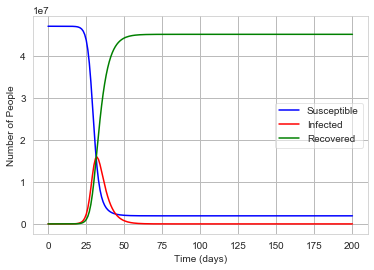

In [24]:
from scipy.integrate import odeint

# total population
N = 47000000
# initial infected
I0 = 2
# initial recovered
R0 = 0
#initial susceptible
S0 = N - I0 - R0

# contact rate
beta = 0.8
# mean recovery rate
#gamma = 0.15
#gamma = Y['Recovered'].sum()/ Y['Cases'].sum() # 0.24
gamma= 0.24


# initial conditions vector
y0 = S0, I0, R0
# 200 evenly spaced values (representing days)
t = np.linspace(0, 200, 200)
# initial conditions vector
y0 = S0, I0, R0
# 200 evenly spaced values (representing days)
t = np.linspace(0, 200, 200)

def func(y, t, N, beta, gamma):
    # S, I, R values assigned from vector
    S, I, R = y
    # differential equations
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

# Integrate the diff eqs over the time array
values = odeint(func, y0, t, args=(N, beta, gamma))
# assign S, I, R values from values transpose
S, I, R = values.T


fig = plt.figure()
ax = fig.add_subplot(111, axisbelow=True)
ax.plot(t, S, 'blue', lw=1.5, label='Susceptible')
ax.plot(t, I, 'red', lw=1.5, label='Infected')
ax.plot(t, R, 'green', lw=1.5, label='Recovered')
ax.set_xlabel('Time (days)')
ax.set_ylabel('Number of People')
ax.grid(b=True, which='major', c='#bbbbbb', lw=1, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
plt.show()

For more information about Compartmental Models you can read the interesting serie of [blog of Bruno Gonçalves](https://medium.com/data-for-science/epidemic-modeling-101-or-why-your-covid19-exponential-fits-are-wrong-97aa50c55f8).
